## 准备

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
import datetime


from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
#     classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
#     class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}

    print('Number of classes :', len(y_ohe[0]))
    
    if len(y_ohe[0]) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    
    # Galaxy Case
    if len(y_ohe[0]) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(y_ohe[0]) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
        
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

## 特征工程

In [8]:
def set_df(arr, col_names):
    df = pd.DataFrame(arr)
    df.columns = col_names
    return df

def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


def add_feats_four_ts_data(df):
#     df['flux_ratio'] = np.absolute(df['flux'] / df['flux_err'])
    df['flux_ratio'] = df['flux'] / df['flux_err']
    return df


def agg_by_flux_feats(df):  
#     df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
#     df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs = {
#         'mjd': ['min', 'max', 'size'],
        'passband': ['mean', 'std', 'var'],  
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'flux_ratio': ['min', 'max', 'mean', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }   

#     aggs['flux_ratio_sq'] = ['sum']
#     aggs['flux_by_flux_ratio_sq'] = ['sum']

    
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_df.columns = new_columns

    agg_df = add_flux_second_order_features_to_agg(df=agg_df)
    
    return agg_df




def add_detection_feats(df, db):   
    print('Adding feats for the flux depending on detection level...')

# ### 均值
#     stats = db.groupby(['object_id','detected'])['flux'].mean().unstack()
#     stats.columns = ['detected_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
          
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)

# ### 方差
#     stats = db.groupby(['object_id','detected'])['flux'].std().unstack()
#     stats.columns = ['detected_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
          
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
# ### 偏度
#     stats = db.groupby(['object_id','detected'])['flux'].skew().unstack()
#     stats.columns = ['detected_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
          
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 最小值
    stats = db.groupby(['object_id','detected'])['flux'].min().unstack()
    stats.columns = ['detected_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
          
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    

# ### 最大值
#     stats = db.groupby(['object_id','detected'])['flux'].max().unstack()
#     stats.columns = ['detected_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
          
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)


    print('Adding feats for the flux ratio depending on detection level...')
### 最小值
    stats = db.groupby(['object_id','detected'])['flux_ratio'].min().unstack()
    stats.columns = ['detected_' + str(col) + '_flux_ratio_min' for col in stats.columns.tolist()]
          
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

### 最大值
    stats = db.groupby(['object_id','detected'])['flux_ratio'].max().unstack()
    stats.columns = ['detected_' + str(col) + '_flux_ratio_max' for col in stats.columns.tolist()]
          
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
### 平均值
    stats = db.groupby(['object_id','detected'])['flux_ratio'].mean().unstack()
    stats.columns = ['detected_' + str(col) + '_flux_ratio_mean' for col in stats.columns.tolist()]
          
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 方差值
    stats = db.groupby(['object_id','detected'])['flux_ratio'].std().unstack()
    stats.columns = ['detected_' + str(col) + '_flux_ratio_std' for col in stats.columns.tolist()]
          
    print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)    
    
    
    return df
    


    
    
def add_flux_second_order_features_to_agg(df):
#     df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
#     df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
#     df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

#     del df['mjd_max'], df['mjd_min']

    return df


def get_by_galaxy(df):
    df_in_gal = df[df['in_galaxy']==1]
    objects_in_gal = df_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    df_out_gal = df[df['in_galaxy']==0]
    objects_out_gal = df_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    print('Total number should be', len(df['object_id'].unique().tolist()))
    return df_in_gal, df_out_gal


def add_feats_within_time_interval_out(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
#                                                                           'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
#                                                                          'interval_{}_flux_skew'.format(i+1):'skew'
                                                                        })
#         print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
# 仅仅看看神经网络在更多特征情况下表现如何
# 结果和GBDT一样变差
        # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
# 仅仅看看神经网络在多特征情况下表现如何         
                
#     # interval_#_flux_？ 互相做差
#     for key in ['max', 'min', 'mean']:
# #     for key in ['mean']:
#         key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
#         for col in key_cols:
#             subtract_cols = [col_ for col_ in key_cols if col_ < col]
#             for sub_col in subtract_cols:
#                 df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

def add_feats_within_time_interval(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
                                                                          'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
                                                                         'interval_{}_flux_skew'.format(i+1):'skew'})
#         print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
# 仅仅看看神经网络在多特征情况下表现如何
# 结果和GBDT一样变差
        # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
# 仅仅看看神经网络在多特征情况下表现如何         
                
    # interval_#_flux_？ 互相做差
    for key in ['max', 'min', 'mean']:
#     for key in ['max']:
        key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
        for col in key_cols:
            subtract_cols = [col_ for col_ in key_cols if col_ < col]
            for sub_col in subtract_cols:
                df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
         

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df






def add_band_when_detected_feats(df, db):
    

    db = db[db.detected == 1]
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['detected_1_band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['detected_1_band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['detected_1_band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['detected_1_band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['detected_1_band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['detected_1_band_' + str(band_n) + '_flux_diff1'] = df['detected_1_band_' + str(band_n) + '_flux_max'] - df['detected_1_band_' + str(band_n) + '_flux_min']
        df['detected_1_band_' + str(band_n) + '_flux_diff2'] = df['detected_1_band_' + str(band_n) + '_flux_diff1']/df['detected_1_band_' + str(band_n) + '_flux_mean']
        # print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df






def add_band_when_not_detected_feats(df, db):
    

    db = db[db.detected == 0]
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['detected_0_band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['detected_0_band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['detected_0_band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['detected_0_band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['detected_0_band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['detected_0_band_' + str(band_n) + '_flux_diff1'] = df['detected_0_band_' + str(band_n) + '_flux_max'] - df['detected_0_band_' + str(band_n) + '_flux_min']
        df['detected_0_band_' + str(band_n) + '_flux_diff2'] = df['detected_0_band_' + str(band_n) + '_flux_diff1']/df['detected_0_band_' + str(band_n) + '_flux_mean']
        # print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df










def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        # print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df

    

def add_photo_feats(df):
    df['hostgal_photoz_ratio'] = df['hostgal_photoz']/df['hostgal_photoz_err']
    
    return df


def get_periods(obs):
    # ob = {'interval':#, 'flux':#, 'mjd':#}
    # 仅保留flux大于均值的observations
    flux_list = []
    for ob in obs:
        ob_f = ob['flux']
#         print('flux :',ob_f)
        flux_list.append(ob_f)
    avg = np.mean(flux_list)
#     print('avg flux :',avg)
    mjd_list = []
    for ob in obs:
        if ob['flux'] > avg:
            mjd_list.append(ob['mjd'])
#     print('mjd list :', mjd_list)
    
    mjd_num = len(mjd_list)
    diff_mjd_list = []
#     print('mjd number :',mjd_num)
    if mjd_num == 1:
        diff_mjd_list = mjd_list.copy()
    else :
        for i in range(mjd_num-1):
            diff_mjd_list.append(mjd_list[i+1]-mjd_list[i])
#     print('diff mjd list :', diff_mjd_list)
    
    mjd_mean = np.mean(diff_mjd_list)
    mjd_std = np.std(diff_mjd_list)
    mjd_size = len(diff_mjd_list)
    
    return mjd_size, mjd_mean, mjd_std
        
def estimate_period(int_n, t_min, t_max, db):
    int_dur = (t_max - t_min)/int_n
    obs = []
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['flux','mjd']]
        if db_fil.shape[0] > 0:
#             print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0])) 
            max_flux_row = db_fil.ix[db_fil['flux'].idxmax()]
            ob = dict()
            ob['flux'] = max_flux_row['flux']
            ob['mjd'] = max_flux_row['mjd']
#             print('observation with max flux:',print(ob))
            obs.append(ob)
    
    mjd_size, mjd_mean, mjd_std = get_periods(obs)
    
#     mjd_period = {'mjd_size':mjd_size, 'mjd_mean':mjd_mean, 'mjd_std':mjd_std}
    
    return mjd_size, mjd_mean, mjd_std
    
    
    
    
def add_period_feats(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    


    ids = db[['object_id','flux']].groupby('object_id')['flux'].mean().index.tolist()
#     print('id size:', len(ids))
    db_period = db[['object_id','flux','mjd']].groupby('object_id', as_index=False).apply(lambda da : pd.Series({'period':estimate_period(int_n, t_min, t_max, da)}))
    
#     print(type(db_period))
#     print(db_period)
#     db_period.columns = ['object_id','period']
    
    db_period['period_size'] = db_period.apply(lambda row : row['period'][0], axis=1)
    db_period['period_flux_mean'] = db_period.apply(lambda row : row['period'][1], axis=1)
    db_period['period_flux_std'] = db_period.apply(lambda row : row['period'][2], axis=1)
#     print('df size:',db_period.shape[0])
    db_period['object_id'] = ids
    del db_period['period']
    print(db_period)
    
    df = df.merge(db_period, on='object_id', how='left').fillna(0)
    print('Period features have been added as followed', df.columns.tolist())
    
    
    return df
    
    
    




def fabriquer_feat(db, meta):
    
    # # 去除无效特征
    # del meta['hostgal_specz']
    # print('Feature hostgal_specz is removed')
    
    # META数据提供划分银河系内外的依据
    # 增加是否属于银河系的特征
    meta.distmod.fillna(0,inplace=True)
    meta['in_galaxy'] = 0
    meta.loc[(meta.distmod == 0), 'in_galaxy'] = 1
    
    # 时序数据特征提取
    db = add_feats_four_ts_data(db)
    
    # 时序数据和META数据融合，形成以mjd为行的数据
    db_meta = db.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for MJD relevant data and META data ', db_meta.shape)
        
    # 基本特征聚合
    agg_df = agg_by_flux_feats(db)
    print('Dimension of aggregated data on flux features', agg_df.shape)
    
    # 对时序融合数据进行分割
    db_in_gal, db_out_gal = get_by_galaxy(db_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', db_in_gal.shape, db_out_gal.shape)
    
    # 聚合数据和META数据融合，形成以object_id为行的数据
    agg_df_meta = agg_df.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for Object relevant data and META data', agg_df_meta.shape)

    # 对object融合数据进行分割
    df_in_gal, df_out_gal = get_by_galaxy(agg_df_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', df_in_gal.shape, df_out_gal.shape)

    if df_in_gal.shape[0] >0:
        # 对银河系内数据提取特征
        print('Features extraction for objects in the Galaxy begins...')
        
        # 增加周期特征
#         df_in_gal = add_period_feats(4, df_in_gal, db_in_gal)

        # 增加detected相关特征
        df_in_gal = add_detection_feats(df_in_gal, db_in_gal)
        
        df_in_gal = add_band_when_detected_feats(df_in_gal, db_in_gal)
        
        df_in_gal = add_band_when_not_detected_feats(df_in_gal, db_in_gal) 
        
        # 增加band相关特征
        df_in_gal = add_band_feats(df_in_gal, db_in_gal)    
        
        # 增加按MJD划分时间统计得到的特征
        df_in_gal = add_feats_within_time_interval(6, df_in_gal, db_in_gal)
        
    
    if df_out_gal.shape[0] >0:
        # 对银河系外数据提取特征
        print('Features extraction for objects out of the Galaxy begins...')
        
#         df_out_gal = add_period_feats(4, df_out_gal, db_out_gal)
        
        # 增加detected相关特征
        df_out_gal = add_detection_feats(df_out_gal, db_out_gal) 
        
        # 增加hostgal_photoz相关特征
        df_out_gal = add_photo_feats(df_out_gal)
        
        df_out_gal = add_band_when_detected_feats(df_out_gal, db_out_gal)
        
        df_out_gal = add_band_when_not_detected_feats(df_out_gal, db_out_gal) 
        
        # 增加band相关特征
        df_out_gal = add_band_feats(df_out_gal, db_out_gal)    
        
        # 增加按MJD划分时间统计得到的特征
        df_out_gal = add_feats_within_time_interval_out(6, df_out_gal, db_out_gal) 
    
    return df_in_gal, df_out_gal

## 神经网络

In [4]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    

def to_cat(y):    
    classes = sorted(np.unique(y))
    
    unique_y = np.unique(y)
    class_map = dict()

    for i,val in enumerate(unique_y):
        class_map[val] = i            
    y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y])
    y_categorical = to_categorical(y_map)    
    
    return y_categorical
    
    
    
def train_by_nn(full_train, y):
    full_train_new = full_train.copy()
    ss = StandardScaler()
    full_train_ss = ss.fit_transform(full_train_new)
    
    classes = sorted(y.unique())
    
    unique_y = np.unique(y)
    class_map = dict()

    for i,val in enumerate(unique_y):
        class_map[val] = i            
    y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y])
    y_categorical = to_categorical(y_map)    

    
    y_count = Counter(y_map)
    wtable = np.zeros((len(unique_y),))
    for i in range(len(unique_y)):
        wtable[i] = y_count[i]/y_map.shape[0]    
    
    
    def mywloss(y_true, y_pred):  
  
        yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
        loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
        return loss
    
#     K.clear_session()
    def build_model(dropout_rate=0.25,activation='relu'):
        start_neurons = 512
        # create model
        model = Sequential()
        model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//2,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//4,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//8,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate/2))
        
        model.add(Dense(len(classes), activation='softmax'))
        return model    
    
        
    clfs = []
    oof_preds = np.zeros((len(full_train_ss), len(classes)))
    epochs = 600
    batch_size = 100
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
        x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
        x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
        
        model = build_model(dropout_rate=0.5,activation='tanh')    
        model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
        history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
        
        plot_loss_acc(history)
        
        print('Loading Best Model')
        model.load_weights('./keras.model')
        # # Get predicted probabilities for each class
        oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
        print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
        clfs.append(model)
    
    return ss, y_categorical, oof_preds, clfs

### 结果分析

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(20,10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    fig.savefig(r'../feat/confusion_matrix_{}.pdf'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    
    

def get_confusion_matrix(y, preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i,val in enumerate(unique_y):
        class_map[val] = i
            
#     y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y]) 
    
    cnf_matrix = confusion_matrix(y_map, np.argmax(preds, axis=-1))  
    np.set_printoptions(precision=2)
    
    
    sample_sub = pd.read_csv('../input/sample_submission.csv')
    class_names = list(sample_sub.columns[1:-1])
    del sample_sub;gc.collect()
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10,10))
    foo = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Confusion matrix')

## 主程序

### 数据准备

In [6]:
gc.enable()

train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')

### 特征提取

In [7]:
# 去除无效特征
del meta_train['hostgal_specz']
print('Feature hostgal_specz is removed')

full_train_in_gal, full_train_out_gal = fabriquer_feat(train, meta_train)

for df in [full_train_in_gal, full_train_out_gal]:
    del df['object_id']
    df_mean = df.mean(axis=0)
    df.fillna(df_mean, inplace=True)

del meta_train, train

Feature hostgal_specz is removed
Dimension of merge data for MJD relevant data and META data  (1421705, 18)
Dimension of aggregated data on flux features (7848, 21)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (400574, 18) (1021131, 18)
Dimension of merge data for Object relevant data and META data (7848, 33)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (2325, 33) (5523, 33)
Features extraction for objects in the Galaxy begins...
Adding feats for the flux depending on detection level...
Feats added: ['detected_0_flux_min', 'detected_1_flux_min']


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:98: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:114: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_

Adding feats for the flux ratio depending on detection level...
Feats added: ['detected_0_flux_ratio_min', 'detected_1_flux_ratio_min']
Feats added: ['detected_0_flux_ratio_max', 'detected_1_flux_ratio_max']
Feats added: ['detected_0_flux_ratio_mean', 'detected_1_flux_ratio_mean']
Feats added: ['detected_0_flux_ratio_std', 'detected_1_flux_ratio_std']
Adding feats for the flux mean per band...
Adding feats for the flux std per band...
Adding feats for the flux skew per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:270: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:279: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:288: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:304: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykerne

Adding feats for the flux max per band...
Adding feats for the flux min per band...
Adding feats for the flux (max-min)/mean per band...
Dimension of data after adding features relevant to bands (2325, 115)
Number of Intervals : 6
Min and Max MJD time : 59580.0347, 60674.363
Interval #1, record quantity: 38277
Interval #2, record quantity: 82096
Interval #3, record quantity: 61348
Interval #4, record quantity: 73604
Interval #5, record quantity: 56390
Interval #6, record quantity: 88858
Dimension of data after adding features relevant to time intervals (2325, 190)
Features extraction for objects out of the Galaxy begins...
Adding feats for the flux depending on detection level...
Feats added: ['detected_0_flux_min', 'detected_1_flux_min']
Adding feats for the flux ratio depending on detection level...
Feats added: ['detected_0_flux_ratio_min', 'detected_1_flux_ratio_min']
Feats added: ['detected_0_flux_ratio_max', 'detected_1_flux_ratio_max']
Feats added: ['detected_0_flux_ratio_mean',

### 训练

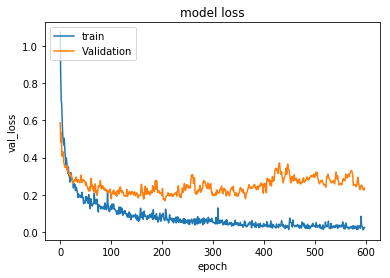

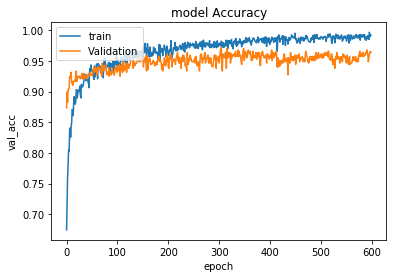

Loading Best Model
Number of classes : 5
0.1677401232303241


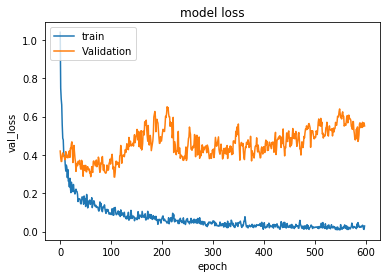

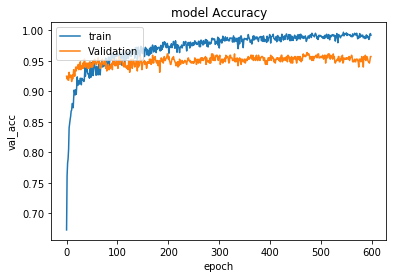

Loading Best Model
Number of classes : 5
0.01419104615636014


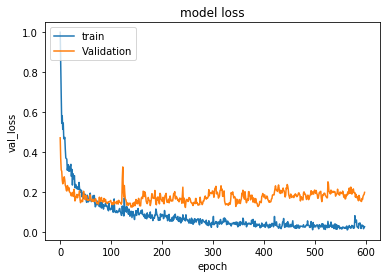

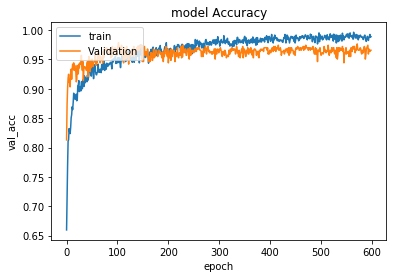

Loading Best Model
Number of classes : 5
0.12371369088644857


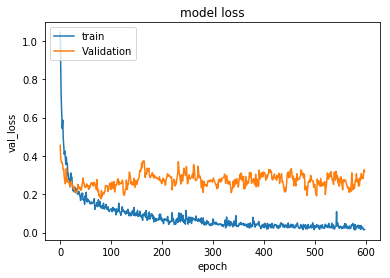

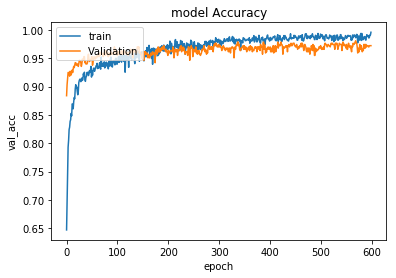

Loading Best Model
Number of classes : 5
0.005469026173747099


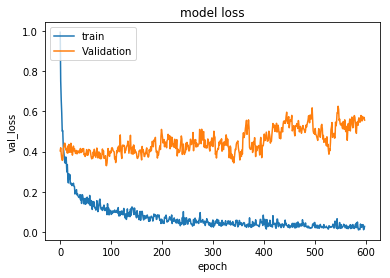

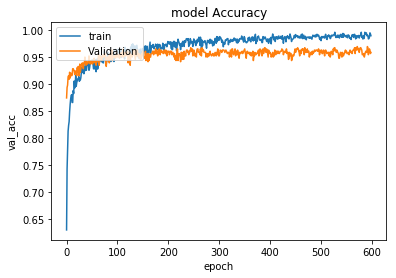

Loading Best Model
Number of classes : 5
0.01406782438180999
Number of classes : 5
MULTI WEIGHTED LOG LOSS : 0.06533 


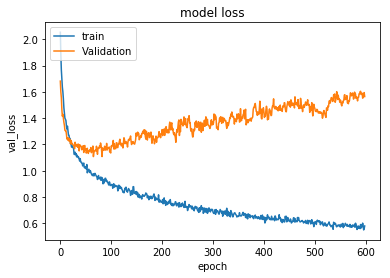

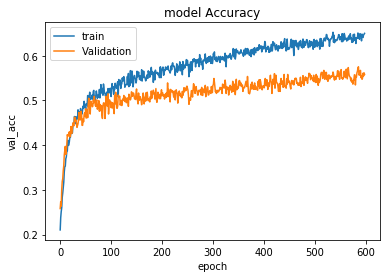

Loading Best Model
Number of classes : 9
1.0620415998424797


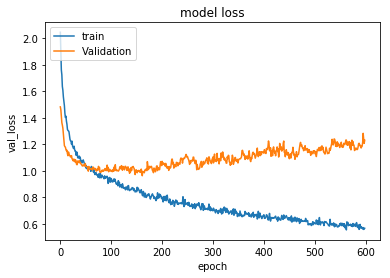

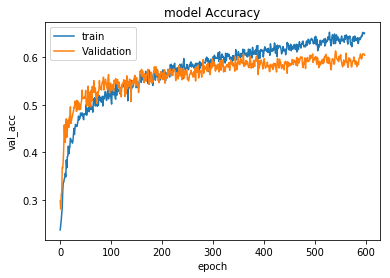

Loading Best Model
Number of classes : 9
0.915387848586888


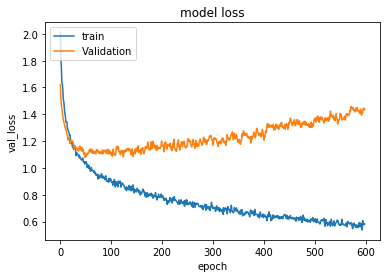

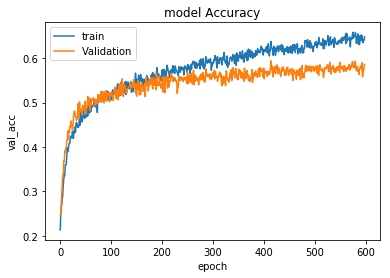

Loading Best Model
Number of classes : 9
0.5480942170281854


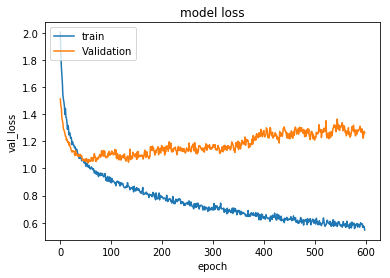

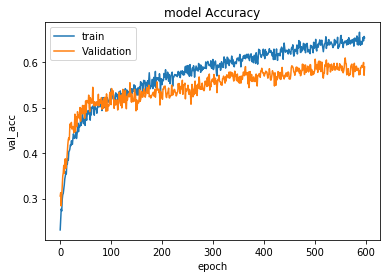

Loading Best Model
Number of classes : 9
0.5306668090781588


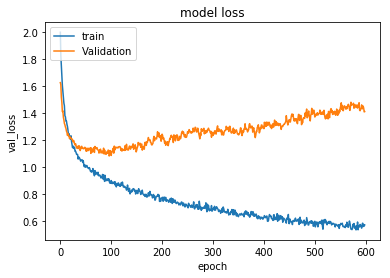

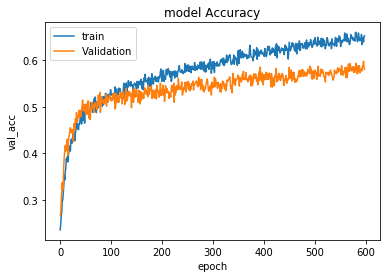

Loading Best Model
Number of classes : 9
0.5660751291511327
Number of classes : 9
MULTI WEIGHTED LOG LOSS : 0.72628 


In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

y_in_gal = full_train_in_gal['target']

train_in_gal = full_train_in_gal.copy()

del train_in_gal['target']

# print('Training begins...')

val_score_list = []
clf_list = []

ss_in, y_categorical_in_gal, oof_preds_in_gal, clf_in = train_by_nn(train_in_gal, y_in_gal)

score_in_gal = multi_weighted_logloss(y_categorical_in_gal,oof_preds_in_gal)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % score_in_gal)
val_score_list.append(score_in_gal)
clf_list.append(clf_in)


y_out_gal = full_train_out_gal['target']

train_out_gal = full_train_out_gal.copy()

del train_out_gal['target']

ss_out, y_categorical_out_gal, oof_preds_out_gal, clf_out = train_by_nn(train_out_gal, y_out_gal)

score_out_gal = multi_weighted_logloss(y_categorical_out_gal,oof_preds_out_gal)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % score_out_gal)
val_score_list.append(score_out_gal)
clf_list.append(clf_out)




### 结果分析

Number of classes : 14
MULTI WEIGHTED LOG LOSS : 0.51973 
               Model     Score
0       Galaxy_Model  0.065335
1  Extragalaxy_Model  0.726278
2           Bi_Model  0.519733
Normalized confusion matrix
[[0.97 0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.   0.01 0.  ]
 [0.   0.82 0.   0.02 0.02 0.   0.02 0.03 0.   0.03 0.   0.05 0.   0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   0.1  0.   0.33 0.12 0.   0.17 0.04 0.   0.08 0.   0.12 0.   0.05]
 [0.   0.01 0.   0.07 0.63 0.   0.1  0.01 0.   0.05 0.   0.13 0.   0.01]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.09 0.07 0.   0.52 0.07 0.   0.18 0.   0.03 0.   0.01]
 [0.   0.02 0.   0.01 0.   0.   0.02 0.92 0.   0.03 0.   0.   0.   0.  ]
 [0.03 0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.05 0.   0.07 0.02 0.   0.79 0.   0.05 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0. 

<Figure size 720x720 with 0 Axes>

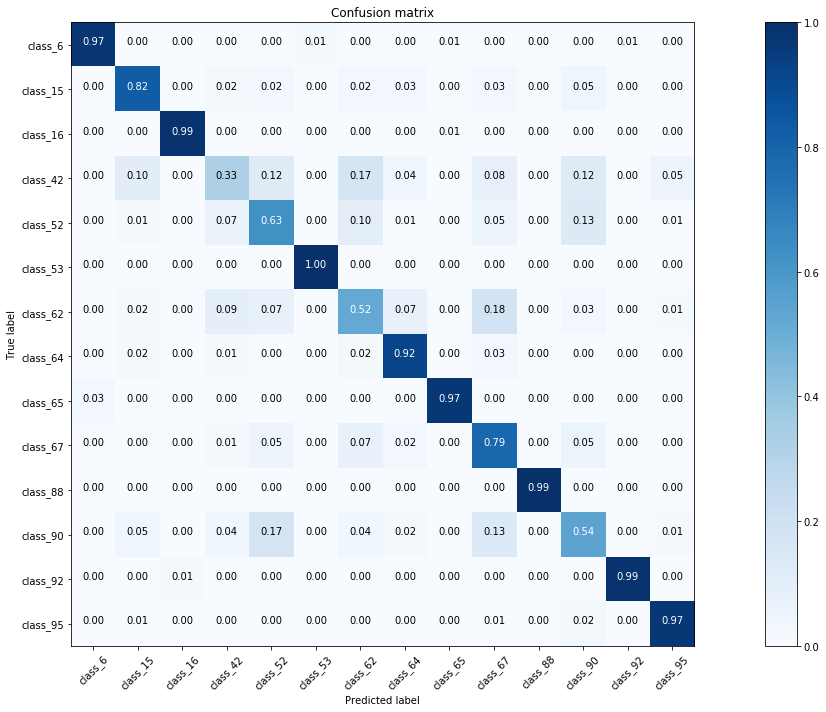

In [9]:
all_y = np.concatenate((y_in_gal.values, y_out_gal.values), axis=0)

in_classes = [6, 16, 53, 65, 92]
out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

in_df = set_df(oof_preds_in_gal, in_classes)
out_df = set_df(oof_preds_out_gal, out_classes)
in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)


# print('Just double check:', multi_weighted_logloss_OLDVERSION(y_true=all_y, y_preds=in_out_df.values))

all_y_cat = to_cat(all_y)

tot_score = multi_weighted_logloss(all_y_cat, in_out_df.values)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % tot_score)

val_score_list.append(tot_score)



score_tab = pd.DataFrame({'Model':['Galaxy_Model', 'Extragalaxy_Model','Bi_Model'], 'Score':val_score_list})
print(score_tab)
score_tab.to_csv(r'../feat/validation_scores_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


get_confusion_matrix(all_y, in_out_df.values)   

## 梯度提升决策树

In [9]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
    
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
        
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}    
        
        
        
        
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [10]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 24))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(r'../feat/importances_{}.png'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    importances_.sort_values('mean_gain', ascending=False).to_csv(r'../feat/feat_rank_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03,
        'subsample': .9,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01,
        'min_child_weight': 10,
        'n_estimators': 1000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3
    }
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    
    print('oof_preds:')
    print(oof_preds)
    
    val_score = multi_weighted_logloss(y_true=y, y_preds=oof_preds)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % val_score)

    return clfs, importances, oof_preds, val_score


In [11]:
import logging

def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

Feature hostgal_specz is removed
Dimension of merge data for MJD relevant data and META data  (1421705, 18)
Dimension of aggregated data on flux features (7848, 21)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (400574, 18) (1021131, 18)
Dimension of merge data for Object relevant data and META data (7848, 33)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (2325, 33) (5523, 33)
Features extraction for objects in the Galaxy begins...
Adding feats for the flux depending on detection level...
Feats added: ['detected_0_flux_min', 'detected_1_flux_min']


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:98: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:106: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:114: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Adding feats for the flux ratio depending on detection level...
Feats added: ['detected_0_flux_ratio_min', 'detected_1_flux_ratio_min']
Feats added: ['detected_0_flux_ratio_max', 'detected_1_flux_ratio_max']
Feats added: ['detected_0_flux_ratio_mean', 'detected_1_flux_ratio_mean']
Feats added: ['detected_0_flux_ratio_std', 'detected_1_flux_ratio_std']
Adding feats for the flux mean per band...
Adding feats for the flux std per band...
Adding feats for the flux skew per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:123: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:274: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:283: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:292: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykerne

Adding feats for the flux max per band...
Adding feats for the flux min per band...
Adding feats for the flux (max-min)/mean per band...
Dimension of data after adding features relevant to bands (2325, 115)
Adding feats for the flux mean per band...
Adding feats for the flux std per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:395: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Adding feats for the flux skew per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:404: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:420: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:438: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:500: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Adding feats for the flux max per band...
Adding feats for the flux min per band...
Adding feats for the flux (max-min)/mean per band...
Dimension of data after adding features relevant to bands (2325, 187)
Adding feats for the flux mean per band...
Adding feats for the flux std per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:509: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Adding feats for the flux skew per band...


C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:518: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:534: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:552: FutureWarning: 'object_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Adding feats for the flux max per band...
Adding feats for the flux min per band...
Adding feats for the flux (max-min)/mean per band...
Dimension of data after adding features relevant to bands (2325, 259)
Number of Intervals : 6
Min and Max MJD time : 59580.0347, 60674.363
Interval #1, record quantity: 38277
Interval #2, record quantity: 82096
Interval #3, record quantity: 61348
Interval #4, record quantity: 73604
Interval #5, record quantity: 56390
Interval #6, record quantity: 88858
Dimension of data after adding features relevant to time intervals (2325, 334)
Features extraction for objects out of the Galaxy begins...
Adding feats for the flux depending on detection level...
Feats added: ['detected_0_flux_min', 'detected_1_flux_min']
Adding feats for the flux ratio depending on detection level...
Feats added: ['detected_0_flux_ratio_min', 'detected_1_flux_ratio_min']
Feats added: ['detected_0_flux_ratio_max', 'detected_1_flux_ratio_max']
Feats added: ['detected_0_flux_ratio_mean',

[INFO]2018-11-06 15:37:16,828:main:Index(['passband_mean', 'passband_std', 'passband_var', 'flux_min', 'flux_max',
       'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_err_min',
       ...
       'interval_4_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_1_flux_mean',
       'interval_5_flux_mean_minus_interval_2_flux_mean',
       'interval_5_flux_mean_minus_interval_3_flux_mean',
       'interval_5_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_1_flux_mean',
       'interval_6_flux_mean_minus_interval_2_flux_mean',
       'interval_6_flux_mean_minus_interval_3_flux_mean',
       'interval_6_flux_mean_minus_interval_4_flux_mean',
       'interval_6_flux_mean_minus_interval_5_flux_mean'],
      dtype='object', length=332)
[INFO]2018-11-06 15:37:16,828:main:Index(['passband_mean', 'passband_std', 'passband_var', 'flux_min', 'flux_max',
       'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_er

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.158337	training's wloss: 0.287624	valid_1's multi_logloss: 0.201627	valid_1's wloss: 0.360054
[200]	training's multi_logloss: 0.0474904	training's wloss: 0.105228	valid_1's multi_logloss: 0.101069	valid_1's wloss: 0.207531
[300]	training's multi_logloss: 0.0268378	training's wloss: 0.063236	valid_1's multi_logloss: 0.0820054	valid_1's wloss: 0.171862
[400]	training's multi_logloss: 0.0204667	training's wloss: 0.0494333	valid_1's multi_logloss: 0.0755938	valid_1's wloss: 0.160249
[500]	training's multi_logloss: 0.0174247	training's wloss: 0.0433066	valid_1's multi_logloss: 0.0715621	valid_1's wloss: 0.15241
[600]	training's multi_logloss: 0.0159022	training's wloss: 0.0403181	valid_1's multi_logloss: 0.0699373	valid_1's wloss: 0.149775
[700]	training's multi_logloss: 0.0149315	training's wloss: 0.0383537	valid_1's multi_logloss: 0.0688438	valid_1's wloss: 0.147361
[800]	training's multi_loglo

[INFO]2018-11-06 15:37:25,683:main:0.14334845660836487
[INFO]2018-11-06 15:37:25,683:main:0.14334845660836487


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.15127	training's wloss: 0.268594	valid_1's multi_logloss: 0.228143	valid_1's wloss: 0.503282
[200]	training's multi_logloss: 0.0426902	training's wloss: 0.0956849	valid_1's multi_logloss: 0.138291	valid_1's wloss: 0.399037
[300]	training's multi_logloss: 0.0248388	training's wloss: 0.060552	valid_1's multi_logloss: 0.126427	valid_1's wloss: 0.369425
[400]	training's multi_logloss: 0.0192676	training's wloss: 0.0490471	valid_1's multi_logloss: 0.124355	valid_1's wloss: 0.367252
Early stopping, best iteration is:
[377]	training's multi_logloss: 0.0202401	training's wloss: 0.0509371	valid_1's multi_logloss: 0.124147	valid_1's wloss: 0.365502


[INFO]2018-11-06 15:37:30,603:main:0.36550166254304517
[INFO]2018-11-06 15:37:30,603:main:0.36550166254304517


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.157625	training's wloss: 0.283797	valid_1's multi_logloss: 0.209669	valid_1's wloss: 0.446541
[200]	training's multi_logloss: 0.0471798	training's wloss: 0.105365	valid_1's multi_logloss: 0.100363	valid_1's wloss: 0.258852
[300]	training's multi_logloss: 0.0272062	training's wloss: 0.0649273	valid_1's multi_logloss: 0.0799073	valid_1's wloss: 0.210311
[400]	training's multi_logloss: 0.0206555	training's wloss: 0.0517665	valid_1's multi_logloss: 0.0735364	valid_1's wloss: 0.199285
[500]	training's multi_logloss: 0.0177313	training's wloss: 0.046149	valid_1's multi_logloss: 0.071667	valid_1's wloss: 0.197686
Early stopping, best iteration is:
[492]	training's multi_logloss: 0.0179107	training's wloss: 0.0464299	valid_1's multi_logloss: 0.0717224	valid_1's wloss: 0.197294


[INFO]2018-11-06 15:37:36,530:main:0.19729365220780656
[INFO]2018-11-06 15:37:36,530:main:0.19729365220780656


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.163799	training's wloss: 0.302831	valid_1's multi_logloss: 0.18912	valid_1's wloss: 0.33354
[200]	training's multi_logloss: 0.0499336	training's wloss: 0.112876	valid_1's multi_logloss: 0.086784	valid_1's wloss: 0.2046
[300]	training's multi_logloss: 0.0282765	training's wloss: 0.0685956	valid_1's multi_logloss: 0.0686189	valid_1's wloss: 0.175341
[400]	training's multi_logloss: 0.0213705	training's wloss: 0.0538257	valid_1's multi_logloss: 0.0630008	valid_1's wloss: 0.167467
[500]	training's multi_logloss: 0.0181663	training's wloss: 0.0470511	valid_1's multi_logloss: 0.0598046	valid_1's wloss: 0.161272
[600]	training's multi_logloss: 0.0165199	training's wloss: 0.0437415	valid_1's multi_logloss: 0.0579023	valid_1's wloss: 0.158368
[700]	training's multi_logloss: 0.0155039	training's wloss: 0.0415296	valid_1's multi_logloss: 0.0569064	valid_1's wloss: 0.155616
[800]	training's multi_logloss

[INFO]2018-11-06 15:37:45,463:main:0.1524598286233695
[INFO]2018-11-06 15:37:45,463:main:0.1524598286233695


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.161589	training's wloss: 0.292087	valid_1's multi_logloss: 0.218236	valid_1's wloss: 0.443933
[200]	training's multi_logloss: 0.048	training's wloss: 0.107524	valid_1's multi_logloss: 0.116125	valid_1's wloss: 0.295576
[300]	training's multi_logloss: 0.0268545	training's wloss: 0.0665985	valid_1's multi_logloss: 0.0983821	valid_1's wloss: 0.271978
[400]	training's multi_logloss: 0.0205363	training's wloss: 0.0528727	valid_1's multi_logloss: 0.092009	valid_1's wloss: 0.263215
[500]	training's multi_logloss: 0.0177224	training's wloss: 0.0466188	valid_1's multi_logloss: 0.0878981	valid_1's wloss: 0.25477
[600]	training's multi_logloss: 0.0161494	training's wloss: 0.0433948	valid_1's multi_logloss: 0.0866592	valid_1's wloss: 0.253606
Early stopping, best iteration is:
[595]	training's multi_logloss: 0.0162175	training's wloss: 0.0435308	valid_1's multi_logloss: 0.0866322	valid_1's wloss: 0.2534

[INFO]2018-11-06 15:37:52,044:main:0.25341383567429576
[INFO]2018-11-06 15:37:52,044:main:0.25341383567429576
[INFO]2018-11-06 15:37:52,055:main:MULTI WEIGHTED LOG LOSS : 0.22212 
[INFO]2018-11-06 15:37:52,055:main:MULTI WEIGHTED LOG LOSS : 0.22212 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


oof_preds:
[[4.55913142e-03 2.57586990e-02 1.75433080e-03 1.76792947e-03
  9.66159909e-01]
 [5.28005852e-04 6.87800805e-04 5.60330224e-04 9.97880264e-01
  3.43599387e-04]
 [6.53392015e-05 5.25213973e-03 1.84097789e-04 9.94411034e-01
  8.73897746e-05]
 ...
 [1.18241629e-02 9.57327139e-01 3.59268426e-03 2.33593742e-02
  3.89663947e-03]
 [7.45143043e-04 1.15053895e-04 1.75131172e-04 9.98835961e-01
  1.28711073e-04]
 [9.91768132e-01 4.53697356e-04 5.25716874e-03 9.42059437e-04
  1.57894273e-03]]


[INFO]2018-11-06 15:38:02,556:main:Index(['passband_mean', 'passband_std', 'passband_var', 'flux_min', 'flux_max',
       'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_err_min',
       ...
       'interval_3_flux_max', 'interval_4_flux_mean', 'interval_4_flux_min',
       'interval_4_flux_max', 'interval_5_flux_mean', 'interval_5_flux_min',
       'interval_5_flux_max', 'interval_6_flux_mean', 'interval_6_flux_min',
       'interval_6_flux_max'],
      dtype='object', length=276)
[INFO]2018-11-06 15:38:02,556:main:Index(['passband_mean', 'passband_std', 'passband_var', 'flux_min', 'flux_max',
       'flux_mean', 'flux_median', 'flux_std', 'flux_skew', 'flux_err_min',
       ...
       'interval_3_flux_max', 'interval_4_flux_mean', 'interval_4_flux_min',
       'interval_4_flux_max', 'interval_5_flux_mean', 'interval_5_flux_min',
       'interval_5_flux_max', 'interval_6_flux_mean', 'interval_6_flux_min',
       'interval_6_flux_max'],
      dtype='object', length=276)


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.901598	training's wloss: 1.11605	valid_1's multi_logloss: 1.01965	valid_1's wloss: 1.39633
[200]	training's multi_logloss: 0.698922	training's wloss: 0.879197	valid_1's multi_logloss: 0.88813	valid_1's wloss: 1.28919
[300]	training's multi_logloss: 0.593402	training's wloss: 0.722873	valid_1's multi_logloss: 0.841951	valid_1's wloss: 1.22345
[400]	training's multi_logloss: 0.518087	training's wloss: 0.607788	valid_1's multi_logloss: 0.82053	valid_1's wloss: 1.19681
[500]	training's multi_logloss: 0.455958	training's wloss: 0.517035	valid_1's multi_logloss: 0.806601	valid_1's wloss: 1.18493
[600]	training's multi_logloss: 0.406291	training's wloss: 0.448102	valid_1's multi_logloss: 0.799336	valid_1's wloss: 1.18379
Early stopping, best iteration is:
[591]	training's multi_logloss: 0.410424	training's wloss: 0.453807	valid_1's multi_logloss: 0.799484	valid_1's wloss: 1.18278


[INFO]2018-11-06 15:38:21,795:main:1.1827824055755292
[INFO]2018-11-06 15:38:21,795:main:1.1827824055755292


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.902439	training's wloss: 1.12804	valid_1's multi_logloss: 1.00553	valid_1's wloss: 1.29699
[200]	training's multi_logloss: 0.694313	training's wloss: 0.876748	valid_1's multi_logloss: 0.870974	valid_1's wloss: 1.19618
[300]	training's multi_logloss: 0.585081	training's wloss: 0.709879	valid_1's multi_logloss: 0.830397	valid_1's wloss: 1.17263
Early stopping, best iteration is:
[343]	training's multi_logloss: 0.54899	training's wloss: 0.653653	valid_1's multi_logloss: 0.820637	valid_1's wloss: 1.17037


[INFO]2018-11-06 15:38:34,894:main:1.170367307337453
[INFO]2018-11-06 15:38:34,894:main:1.170367307337453


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.894232	training's wloss: 1.12125	valid_1's multi_logloss: 1.03376	valid_1's wloss: 1.33138
[200]	training's multi_logloss: 0.684334	training's wloss: 0.86177	valid_1's multi_logloss: 0.905055	valid_1's wloss: 1.22258
[300]	training's multi_logloss: 0.573806	training's wloss: 0.691874	valid_1's multi_logloss: 0.869764	valid_1's wloss: 1.19134
[400]	training's multi_logloss: 0.495124	training's wloss: 0.570578	valid_1's multi_logloss: 0.855016	valid_1's wloss: 1.18906
Early stopping, best iteration is:
[351]	training's multi_logloss: 0.530552	training's wloss: 0.624813	valid_1's multi_logloss: 0.860057	valid_1's wloss: 1.18679


[INFO]2018-11-06 15:38:48,186:main:1.186794902822425
[INFO]2018-11-06 15:38:48,186:main:1.186794902822425


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.900543	training's wloss: 1.12104	valid_1's multi_logloss: 1.0144	valid_1's wloss: 1.3312
[200]	training's multi_logloss: 0.691931	training's wloss: 0.869353	valid_1's multi_logloss: 0.877857	valid_1's wloss: 1.20305
[300]	training's multi_logloss: 0.583909	training's wloss: 0.706634	valid_1's multi_logloss: 0.8325	valid_1's wloss: 1.157
[400]	training's multi_logloss: 0.5071	training's wloss: 0.588596	valid_1's multi_logloss: 0.81294	valid_1's wloss: 1.13978
[500]	training's multi_logloss: 0.445744	training's wloss: 0.498106	valid_1's multi_logloss: 0.801612	valid_1's wloss: 1.13524
Early stopping, best iteration is:
[455]	training's multi_logloss: 0.471464	training's wloss: 0.535564	valid_1's multi_logloss: 0.804695	valid_1's wloss: 1.13279


[INFO]2018-11-06 15:39:04,284:main:1.132790715432912
[INFO]2018-11-06 15:39:04,284:main:1.132790715432912


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.903531	training's wloss: 1.12316	valid_1's multi_logloss: 1.00474	valid_1's wloss: 1.34433
[200]	training's multi_logloss: 0.697482	training's wloss: 0.879504	valid_1's multi_logloss: 0.869833	valid_1's wloss: 1.23422
[300]	training's multi_logloss: 0.590227	training's wloss: 0.716618	valid_1's multi_logloss: 0.83033	valid_1's wloss: 1.18665
[400]	training's multi_logloss: 0.51414	training's wloss: 0.598163	valid_1's multi_logloss: 0.81157	valid_1's wloss: 1.17058
[500]	training's multi_logloss: 0.452114	training's wloss: 0.507652	valid_1's multi_logloss: 0.801361	valid_1's wloss: 1.16282
Early stopping, best iteration is:
[467]	training's multi_logloss: 0.47167	training's wloss: 0.535731	valid_1's multi_logloss: 0.803469	valid_1's wloss: 1.16157


[INFO]2018-11-06 15:39:21,183:main:1.161571725575528
[INFO]2018-11-06 15:39:21,183:main:1.161571725575528
[INFO]2018-11-06 15:39:21,197:main:MULTI WEIGHTED LOG LOSS : 1.16745 
[INFO]2018-11-06 15:39:21,197:main:MULTI WEIGHTED LOG LOSS : 1.16745 
C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


oof_preds:
[[2.95210433e-04 9.65745938e-04 3.11310253e-04 ... 9.96374924e-01
  7.93861367e-04 5.28277654e-04]
 [6.57317114e-03 2.26274950e-01 1.41177899e-01 ... 1.55240962e-03
  2.76087123e-01 1.71410286e-03]
 [4.40501024e-03 7.73543772e-02 4.50937394e-02 ... 7.50649325e-04
  8.58630366e-01 1.01192444e-03]
 ...
 [9.68780536e-01 2.01253556e-02 9.70642096e-04 ... 3.08075389e-04
  5.99162190e-03 2.43948330e-03]
 [3.18311393e-02 5.85763598e-01 8.90035193e-02 ... 8.98014599e-04
  2.55302575e-01 4.62491508e-04]
 [1.09392037e-01 4.08210674e-01 1.27445451e-02 ... 5.01977436e-03
  4.04918264e-01 5.29613087e-03]]
Let us check the logloss when objects are trained separately...
Separate MULTI WEIGHTED LOG LOSS : 0.87203 
               Model     Score
0       Galaxy_Model  0.222117
1  Extragalaxy_Model  1.167452
2           Bi_Model  0.872035


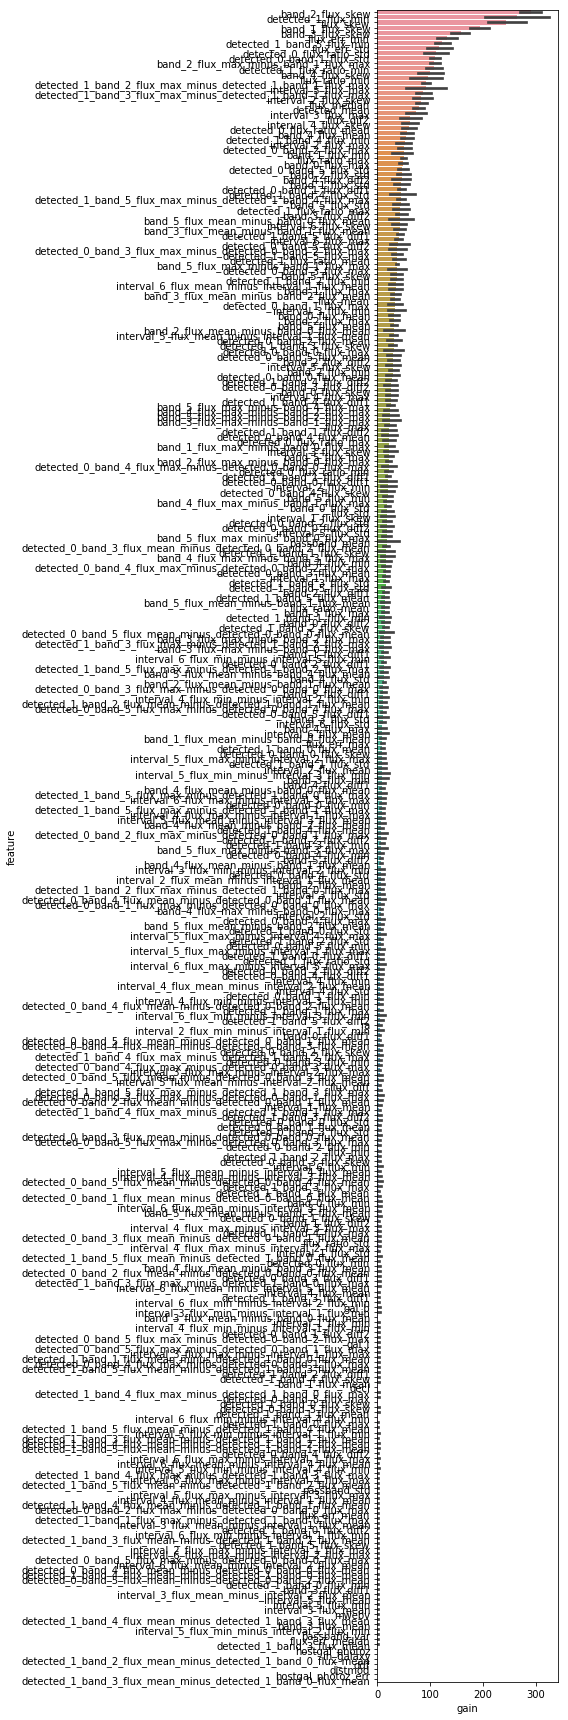

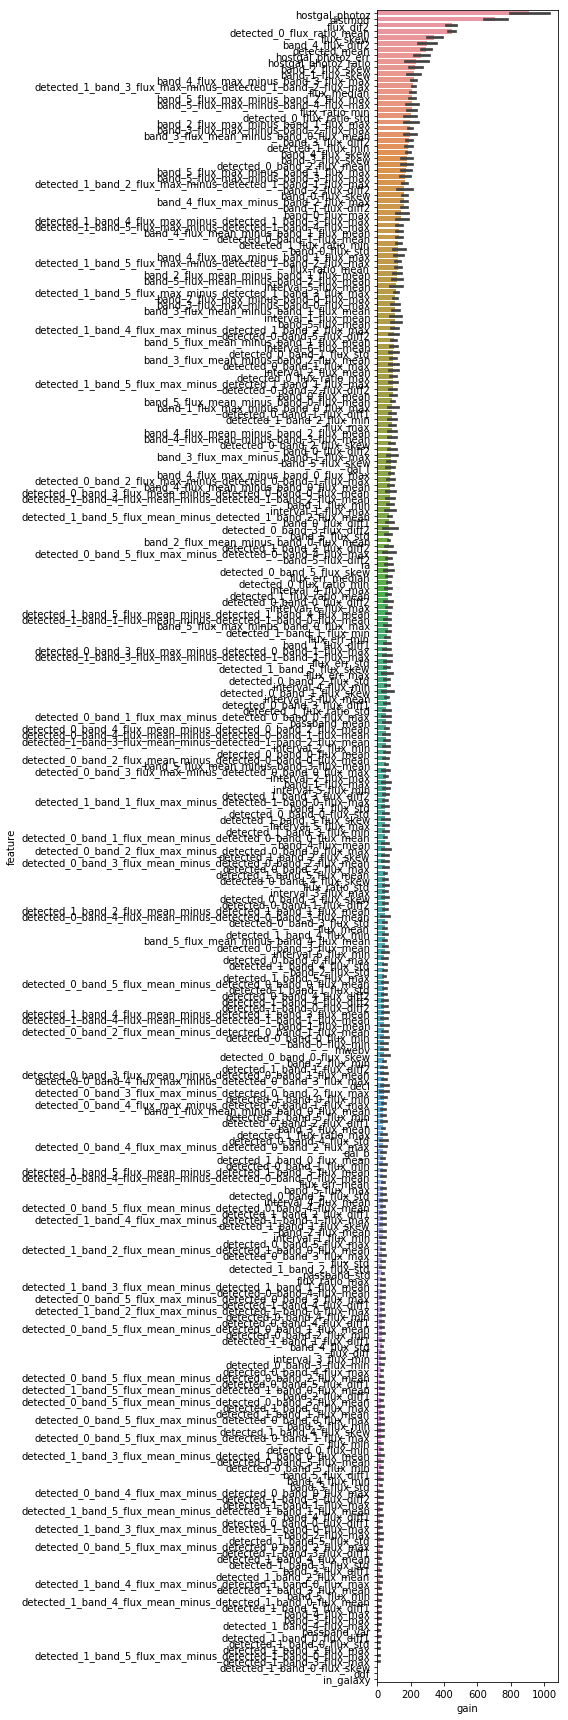

In [12]:
gc.enable()
create_logger()

train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')


# 去除无效特征
del meta_train['hostgal_specz']
print('Feature hostgal_specz is removed')

full_train_in_gal, full_train_out_gal = fabriquer_feat(train, meta_train)



y_list = []
preds_list = []
clf_list = []
val_score_list = []
for df in [full_train_in_gal, full_train_out_gal]:
    del df['object_id']
    df_mean = df.mean(axis=0)
    df.fillna(df_mean, inplace=True)
    y = df['target']
    y_list.append(y)
    del df['target']
    gc.collect()
    get_logger().info(df.columns)

    clfs, importances, preds, val_score = train_classifiers(df, y)
    save_importances(importances_=importances)
    preds_list.append(preds)
    clf_list.append(clfs)
    val_score_list.append(val_score)

    

    
    
    


print('Let us check the logloss when objects are trained separately...')
# all_y = pd.concat(y_list, ignore_index=True)
all_y = np.concatenate((y_list[0], y_list[1]), axis=0)

preds_in_gal = preds_list[0]
preds_out_gal = preds_list[1]
in_classes = [6, 16, 53, 65, 92]
out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

in_df = set_df(preds_in_gal, in_classes)
out_df = set_df(preds_out_gal, out_classes)
in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)


val_score_tot = multi_weighted_logloss(y_true=all_y, y_preds=in_out_df.values)

print('Separate MULTI WEIGHTED LOG LOSS : %.5f ' % val_score_tot)

val_score_list.append(val_score_tot)

score_tab = pd.DataFrame({'Model':['Galaxy_Model', 'Extragalaxy_Model','Bi_Model'], 'Score':val_score_list})
print(score_tab)
score_tab.to_csv(r'../feat/validation_scores_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)